In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import missingno as msno

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Interpretable machine learning
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve
from yellowbrick.model_selection import FeatureImportances

# Notebook configurations
sns.set_style('ticks')
sns.set_context("paper")
sns.set_palette("Set1")

In [2]:
# LIME
import lime
import lime.lime_tabular

In [3]:
# From nightly build of Scikit-Learn
from sklearn.inspection import permutation_importance

# Getting started

In [9]:
movies = pd.read_csv('dataset.csv')
movies.head()

,title,Production_Budget,id,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,cast_5,casting,composer,director,producer,screenplay,keyword_1,keyword_2,keyword_3,target
0,Edge of Tomorrow,178000000,137113,113.0,1,0,0,0,0,0,...,Jonas Armstrong,Lucinda Syson,Christophe Beck,Doug Liman,Erwin Stoff,Christopher McQuarrie,deja vu,time warp,restart,1
1,Up,175000000,14160,96.0,0,0,1,1,0,0,...,Delroy Lindo,Kevin Reher,NaN,Pete Docter,Jonas Rivera,Bob Peterson,age difference,central and south america,balloon,1
2,Cars 3,175000000,260514,102.0,0,1,1,1,0,0,...,Larry the Cable Guy,Kevin Reher,Randy Newman,Brian Fee,Kevin Reher,Bob Peterson,cgi,anthropomorphism,NaN,1
3,G.I. Joe: The Rise of Cobra,175000000,14869,118.0,1,1,0,0,0,0,...,Joseph Gordon-Levitt,Ronna Kress,Alan Silvestri,Stephen Sommers,Lorenzo Di Bonaventura,Stuart Beattie,terrorist,secret,hostage,1
4,The Mummy: Tomb of the Dragon Emperor,175000000,1735,112.0,1,1,0,0,0,0,...,Luke Ford,Ronna Kress,NaN,Rob Cohen,Stephen Sommers,Miles Millar,NaN,NaN,NaN,1


In [10]:
movies['runtime'].fillna((movies['runtime'].mean()), inplace=True)

movies.drop(['prod_company_2', 'prod_company_3', 'casting', 'composer', 'screenplay', 'keyword_2', 'keyword_3'],
       axis=1,
       inplace=True)

movies.drop(['title', 'id'], inplace=True, axis=1)

# Shuffle the data to destroy order
shuffle_df = movies.sample(frac=1).reset_index(drop=True)

In [14]:
# movies = pd.get_dummies(movies, columns=['release_month', 'release_day'])

In [11]:
# ---- Splitting to train and test sets ---------

# Train set
train = shuffle_df.iloc[:2000, :]
y_train = train['target']
X_train = train.drop('target', axis=1)

# Test set
test = shuffle_df.iloc[2000:, :]
y_test = test['target']
X_test = test.drop('target', axis=1)

***
# LeaveOneOutEncoding

In [12]:
# Train set
X_train_enc = ce.LeaveOneOutEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1'],
                                    sigma=0.05
                                   ).fit_transform(X_train, y_train)

# Test set
X_test_enc = ce.LeaveOneOutEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                                  ).fit_transform(X_test, y_test)

## Class reweight:

In [57]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             class_weight= {0:2, 1:1},
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_enc, y_train)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.83      0.58       253
           1       0.81      0.41      0.54       444

    accuracy                           0.56       697
   macro avg       0.63      0.62      0.56       697
weighted avg       0.68      0.56      0.56       697



[ROCAUC score](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)

In [58]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.3f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.655


Unnormalized confusion matrix:
 [[211  42]
 [263 181]]


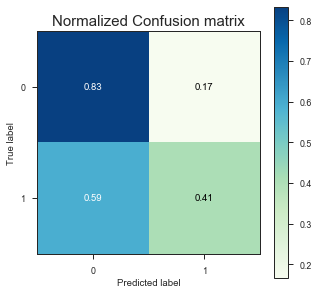

In [59]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## SMOTE oversampling:

Oversampling only done on train set ([source](https://beckernick.github.io/oversampling-modeling/)):

In [60]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [61]:
np.bincount(y_train_smote)

array([1253, 1253], dtype=int64)

In [69]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_smote, y_train_smote)


# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.22      0.32       253
           1       0.67      0.92      0.78       444

    accuracy                           0.67       697
   macro avg       0.64      0.57      0.55       697
weighted avg       0.65      0.67      0.61       697



In [70]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.3f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.569


Unnormalized confusion matrix:
 [[ 55 198]
 [ 35 409]]


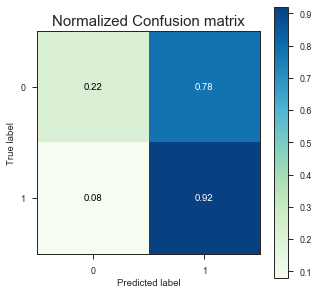

In [71]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## ADASYN oversampling

In [72]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [73]:
np.bincount(y_train_adasyn)

array([1228, 1253], dtype=int64)

In [74]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_adasyn, y_train_adasyn)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.63      0.51       253
           1       0.71      0.52      0.60       444

    accuracy                           0.56       697
   macro avg       0.57      0.57      0.55       697
weighted avg       0.61      0.56      0.57       697



In [84]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.66


Unnormalized confusion matrix:
 [[160  93]
 [215 229]]


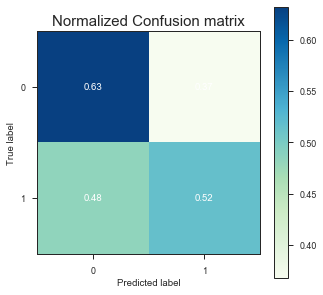

In [76]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

***
# CatBoost encoding

In [78]:
# Train set
X_train_enc = ce.CatBoostEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1'],
                                    sigma=0.05
                                   ).fit_transform(X_train, y_train)

# Test set
X_test_enc = ce.CatBoostEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                                  ).fit_transform(X_test, y_test)

## Class reweight

In [80]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             class_weight={0:2, 1:1},
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_enc, y_train)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       253
           1       0.75      0.73      0.74       444

    accuracy                           0.67       697
   macro avg       0.65      0.65      0.65       697
weighted avg       0.68      0.67      0.67       697



In [81]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.66


Unnormalized confusion matrix:
 [[145 108]
 [120 324]]


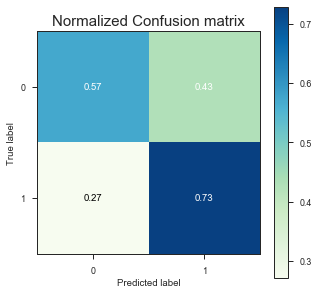

In [82]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## SMOTE oversampling

In [85]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [86]:
np.bincount(y_train_smote)

array([1253, 1253], dtype=int64)

In [87]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_smote, y_train_smote)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.70      0.56       253
           1       0.76      0.55      0.64       444

    accuracy                           0.61       697
   macro avg       0.62      0.63      0.60       697
weighted avg       0.66      0.61      0.61       697



In [88]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.65


Unnormalized confusion matrix:
 [[177  76]
 [199 245]]


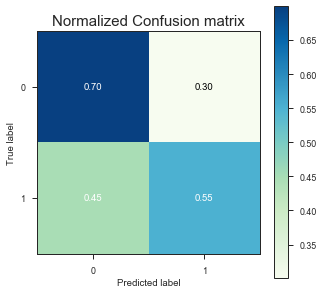

In [89]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## ADASYN oversampling

In [90]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [91]:
np.bincount(y_train_adasyn)

array([1229, 1253], dtype=int64)

In [93]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_adasyn, y_train_adasyn)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.22      0.32       253
           1       0.67      0.92      0.78       444

    accuracy                           0.67       697
   macro avg       0.64      0.57      0.55       697
weighted avg       0.65      0.67      0.61       697



In [94]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.57


Unnormalized confusion matrix:
 [[ 55 198]
 [ 35 409]]


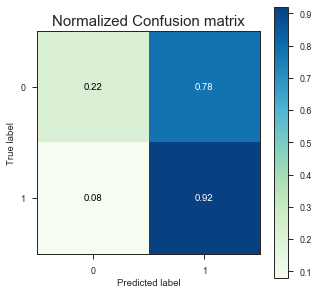

In [95]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

***
# Target encoding

All of these below are overfit. We will just use them as they are as an example of overfitting.

In [96]:
# Train set
X_train_enc = ce.TargetEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1'],
                               smoothing=200
                                   ).fit_transform(X_train, y_train)

# Test set
X_test_enc = ce.TargetEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                    'director', 'producer', 'keyword_1']
                                  ).fit_transform(X_test, y_test)

## Class reweight

In [99]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             class_weight={0:2, 1:1},
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_enc, y_train)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       253
           1       0.97      0.79      0.87       444

    accuracy                           0.85       697
   macro avg       0.85      0.87      0.85       697
weighted avg       0.88      0.85      0.85       697



In [100]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.89


Unnormalized confusion matrix:
 [[243  10]
 [ 95 349]]


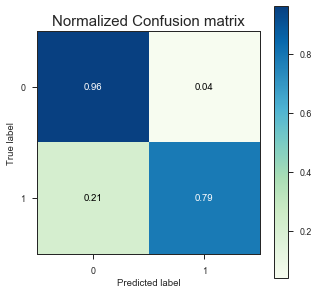

In [101]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

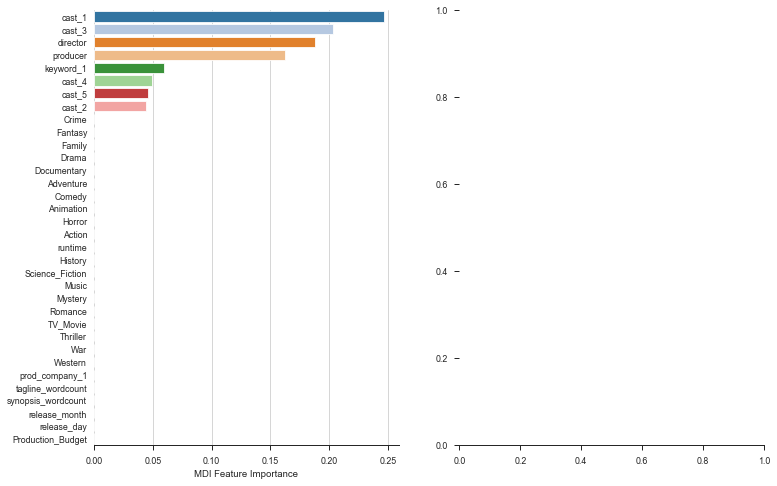

In [103]:
# Mean-decrease-in-impurity (MDI)
fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(fi.values, fi.index, ax=ax1, palette='tab20')
sns.despine(left=True)
ax1.xaxis.grid(True)
ax1.tick_params(axis='y', length=0)
ax1.set_xlabel('MDI Feature Importance')
#ax1.set_xticklabels(fi.index)

plt.show()

## SMOTE resampling

In [104]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [105]:
np.bincount(y_train_smote)

array([1253, 1253], dtype=int64)

In [106]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_smote, y_train_smote)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.96      0.70       253
           1       0.96      0.55      0.70       444

    accuracy                           0.70       697
   macro avg       0.76      0.75      0.70       697
weighted avg       0.81      0.70      0.70       697



In [107]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.81


Unnormalized confusion matrix:
 [[244   9]
 [202 242]]


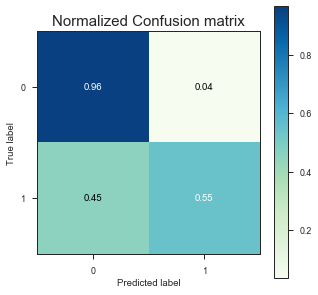

In [108]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## ADASYN resampling

In [132]:
X_train_adasyn, y_train_adaysn = ADASYN().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [134]:
np.bincount(y_train_adasyn)

array([1229, 1253], dtype=int64)

In [136]:
clf = DecisionTreeClassifier(splitter='best',
                             min_samples_split= 18,
                             min_samples_leaf= 2,
                             max_features= 'auto',
                             max_depth=70,
                             criterion= 'entropy',
                             ccp_alpha= 0.020202020202020204,
                            random_state=1
                            ).fit(X_train_adasyn, y_train_adasyn[:-2])

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.96      0.72       253
           1       0.97      0.59      0.73       444

    accuracy                           0.73       697
   macro avg       0.77      0.78      0.73       697
weighted avg       0.82      0.73      0.73       697



In [137]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.85


Unnormalized confusion matrix:
 [[244   9]
 [182 262]]


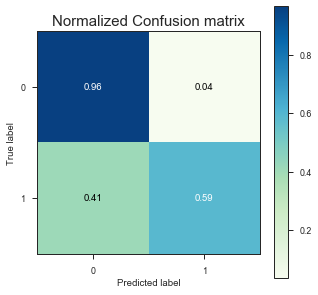

In [138]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

# APPENDIX: Additive smoothing

[source](https://maxhalford.github.io/blog/target-encoding-done-the-right-way/)

In [149]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [110]:
X_train.columns

Index(['Production_Budget', 'runtime', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science_Fiction',
       'TV_Movie', 'Thriller', 'War', 'Western', 'prod_company_1',
       'tagline_wordcount', 'synopsis_wordcount', 'release_month',
       'release_day', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'director', 'producer', 'keyword_1'],
      dtype='object')

In [157]:
# Train set
train = shuffle_df.iloc[:2000, :]

# Test set
test = shuffle_df.iloc[2000:, :]

In [158]:
cat_cols = ['prod_company_1', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5', 'director', 'producer', 'keyword_1']
for col in cat_cols:
    train.loc[:, col] = calc_smooth_mean(train, by=col, on='target', m=200)

In [159]:
for col in cat_cols:
    test.loc[:, col] = calc_smooth_mean(test, by=col, on='target', m=200)

In [160]:
# Train set
y_train = train['target']
X_train = train.drop('target', axis=1)

# Test set
y_test = test['target']
X_test = test.drop('target', axis=1)

In [161]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [162]:
test

,Production_Budget,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,release_day,cast_1,cast_2,cast_3,cast_4,cast_5,director,producer,keyword_1,target
2000,28000000,110.0,0,0,0,1,0,0,1,0,...,12,0.624295,0.627401,0.627401,0.627401,0.627401,0.631072,0.638608,0.627401,1
2001,2000000,100.0,0,0,0,0,0,0,1,0,...,20,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,0.626146,0.627401,1
2002,25000000,97.0,0,0,0,1,0,0,1,0,...,13,0.627401,0.626146,0.627401,0.627401,0.624295,0.627401,0.643370,0.638201,1
2003,55000000,214.0,0,0,0,0,0,0,1,0,...,21,0.622426,0.622426,0.622426,0.624295,0.622426,0.622426,0.622426,0.622426,0
2004,40000000,111.0,0,1,0,0,0,0,1,0,...,22,0.619345,0.622426,0.622426,0.622426,0.622426,0.622426,0.622426,0.622426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,90000000,128.0,0,0,0,0,1,0,0,0,...,8,0.626146,0.627401,0.627401,0.627401,0.627401,0.627401,0.643370,0.617740,1
2693,55000000,91.0,0,0,1,1,0,0,0,1,...,30,0.624295,0.626146,0.627401,0.627401,0.629246,0.627401,0.632880,0.638201,1
2694,12000000,99.0,0,0,0,0,0,0,1,0,...,28,0.627401,0.629246,0.627401,0.627401,0.627401,0.627401,0.631072,0.627401,1
2695,30000,89.0,0,0,0,1,0,0,1,0,...,20,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,1


# Appendix: Randomized search

In [24]:
class_weight = ['balanced', {0:2, 1:1}, {0:5, 1:1}, {0:10, 1:1}] # class of reweight


# The function to measure the quality of a split. 
# Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
criterion = ['gini', 'entropy']

#The strategy used to choose the split at each node. 
# Supported strategies are “best” to choose the best split and “random” to choose the best random split.
splitter= ['best','random']

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 12, 14, 18, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]


 


# Method of selecting samples for training each tree


ccp_alpha = [float(x) for x in np.linspace(0, 1, num = 100)]

random_grid ={
             'criterion':criterion,
             'splitter':splitter,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_features':max_features,
             'ccp_alpha':ccp_alpha,
             'class_weight':class_weight
            }

In [26]:
clf = DecisionTreeClassifier()
clf_random = RandomizedSearchCV(estimator=clf, 
                                param_distributions=random_grid, 
                                n_iter=100, 
                                cv=10, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs=-1)# Fit the random search model

clf_random.fit(X_train_enc, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 877 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.7s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
         

In [27]:
clf_random.best_params_

{'splitter': 'best',
 'min_samples_split': 18,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 70,
 'criterion': 'entropy',
 'class_weight': {0: 2, 1: 1},
 'ccp_alpha': 0.020202020202020204}